In [67]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import QuantumCircuit, execute, Aer
from qiskit import BasicAer
from sklearn.decomposition import PCA


import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
import pandas as pd

algorithm_globals.random_seed = 12345

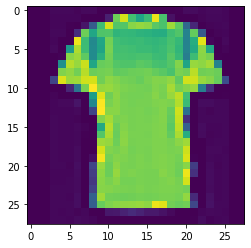

In [9]:
data_path='data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1])

## qPCA to reduce dimensionality and reduce qubit usage
We reduce the dimensions of the image and reduce the no. of qubits required thus reducing noise and improving encoding accuracy.

In [51]:
# Peform qPCA to reduce dimensionality
imgs = np.array(list(map(lambda x: x.flatten(), images)))
pca_sk = PCA(n_components=8)
pca_sk.fit(imgs)
imgs_pca = pca_sk.transform(imgs)

Text(0, 0.5, 'explained variance')

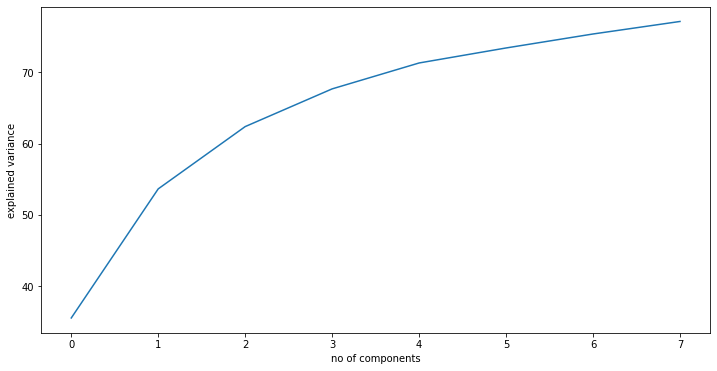

In [52]:
plt.plot(np.cumsum(pca_sk.explained_variance_ratio_ * 100))
plt.xlabel('no of components')
plt.ylabel('explained variance')

## QCNN implementation

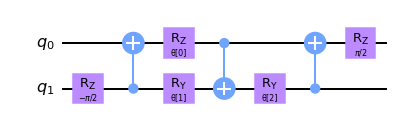

In [53]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

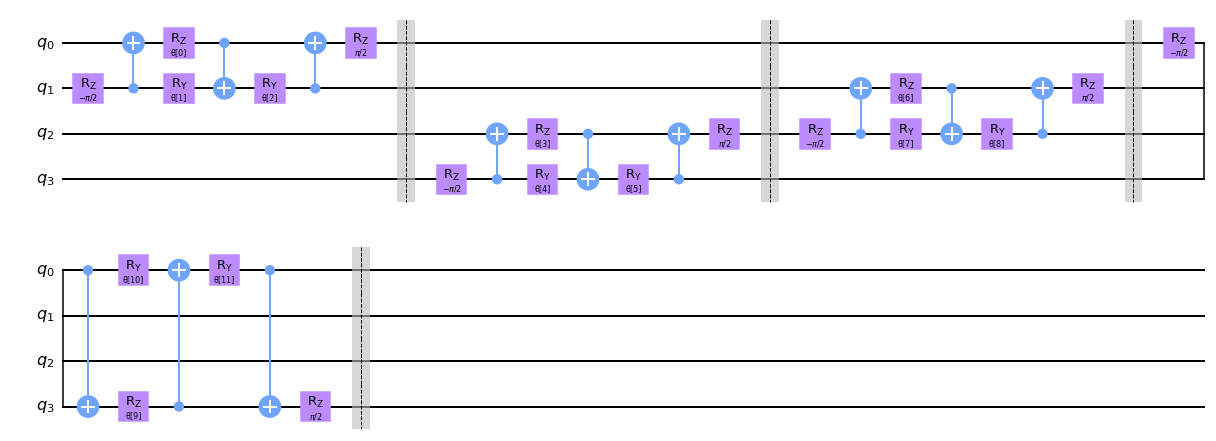

In [54]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

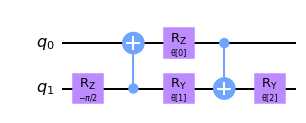

In [55]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

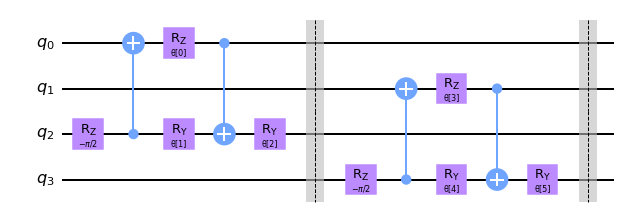

In [56]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [61]:
images = imgs_pca #Using pca images
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

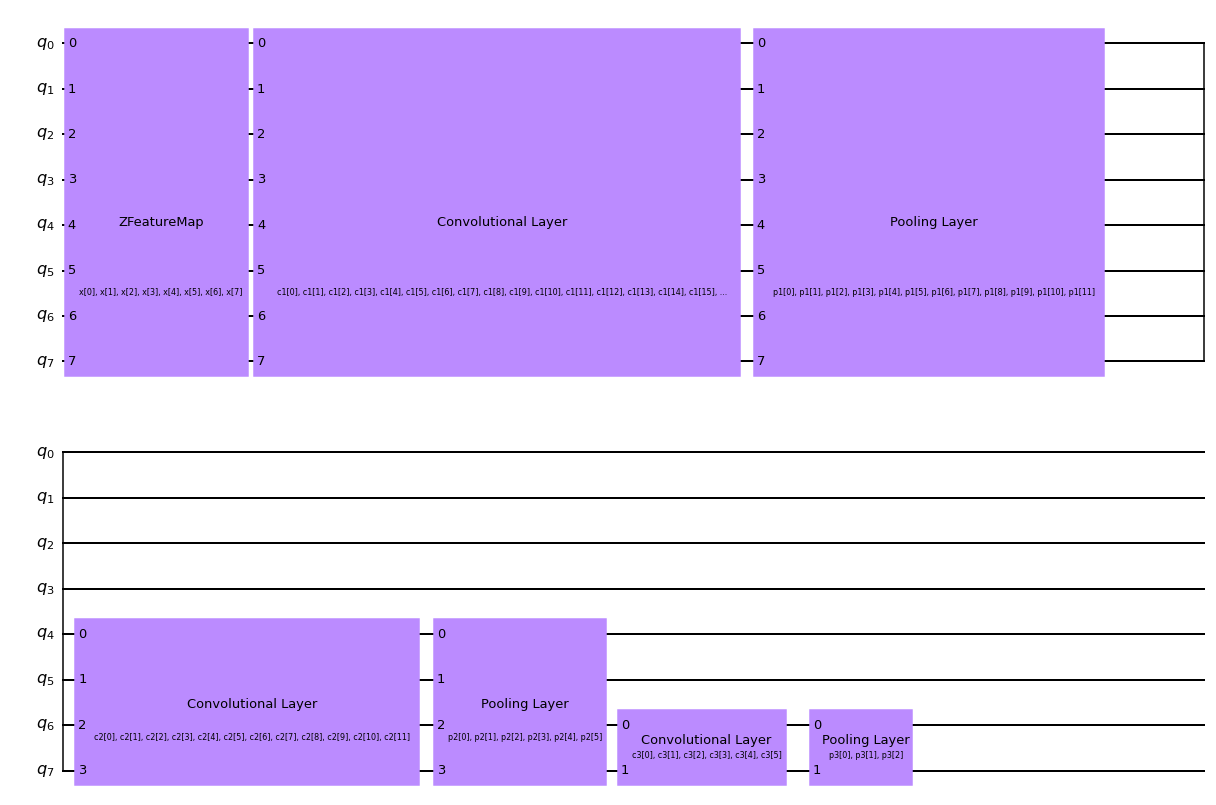

In [62]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl")

In [63]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [64]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

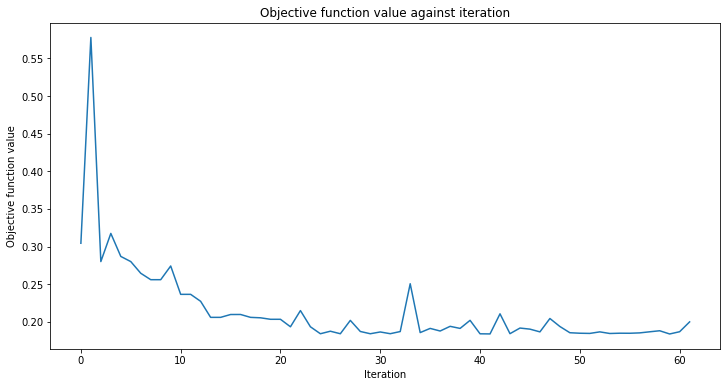

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [ ]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)